Made by : @3koozy
https://github.com/3koozy

In [ ]:
# Prequisites / requirments:
!pip install segmentation-models-pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.3/121.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#import needed libraries:
import torch
import torchvision
from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models_pytorch as smp
import os
from matplotlib.colors import ListedColormap

In [ ]:
#Check mounted device type:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
#Check GPU details if found:
!nvidia-smi

Wed Apr  9 19:09:08 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             44W /  400W |       5MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [ ]:
#Function to extract list of dataset files from location in storage mounted in Colab/GDrive:
def list_files_in_directory(directory):
    file_paths = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            file_paths.append(os.path.join(root, file))
    return file_paths

In [ ]:
#Define paths to dataset location (train & test):
train_image_path = "/content/drive/MyDrive/datasets/FloodNet-Supervised_v1.0/train/train-org-img"
train_label_path = "/content/drive/MyDrive/datasets/FloodNet-Supervised_v1.0/train/train-label-img"
test_image_path = "/content/drive/MyDrive/datasets/FloodNet-Supervised_v1.0/test/test-org-img"
test_label_path = "/content/drive/MyDrive/datasets/FloodNet-Supervised_v1.0/test/test-label-img"

#extract list of images and masks from defined paths:
train_image_list = list_files_in_directory(train_image_path)
train_label_list = list_files_in_directory(train_label_path)
test_image_list = list_files_in_directory(test_image_path)
test_label_list = list_files_in_directory(test_label_path)

In [ ]:
#Custom defined Pytorch ImageFolder dataset
class FloodNetDataset(Dataset):
    """FloodNet dataset."""

    def __init__(self, objects_list, labels_list, transform=None):
        """
        Args:
            objects_list (list): list of image paths to be used with the dataloader.
            labels_list (list): list of segmentation image labels paths to be used with the dataloader.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.objects_list = objects_list
        self.labels_list = labels_list
        self.transform = transform

    def __len__(self):
        return len(self.objects_list)

    def __getitem__(self, idx):
        image = Image.open(self.objects_list[idx])
        label = Image.open(self.labels_list[idx])

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)

        return image, label

In [ ]:
#Transform:
transform = transforms.Compose([transforms.PILToTensor(),
                                transforms.Resize((64,64))]) #transforms.PILToTensor()
#Define datasets:
train_dataset = FloodNetDataset(objects_list=train_image_list, labels_list=train_label_list, transform=transform)
test_dataset = FloodNetDataset(objects_list=test_image_list, labels_list=test_label_list, transform=transform)

In [ ]:
#Define Dataloader:
batch_size = 16

floodnet_dataloader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
floodnet_dataloader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
#QoL Setup:
# Specify colors for each class using hex codes
class_colors = [
    "#000000", "#ff001e", "#ff8f9c", "#56a100",
    "#b3b3b3", "#3bfcff", "#0004ff", "#ff00ff",
    "#f2ff00", "#00ff1e"
]

class_names = [
    'Background', 'Building-Flooded', 'Building-Non-Flooded', 'Road-Flooded',
    'Road-non-Flooded', 'Water', 'Tree', 'Vechile',
    'Pool', 'Grass'
]

colormap = ListedColormap(class_colors)

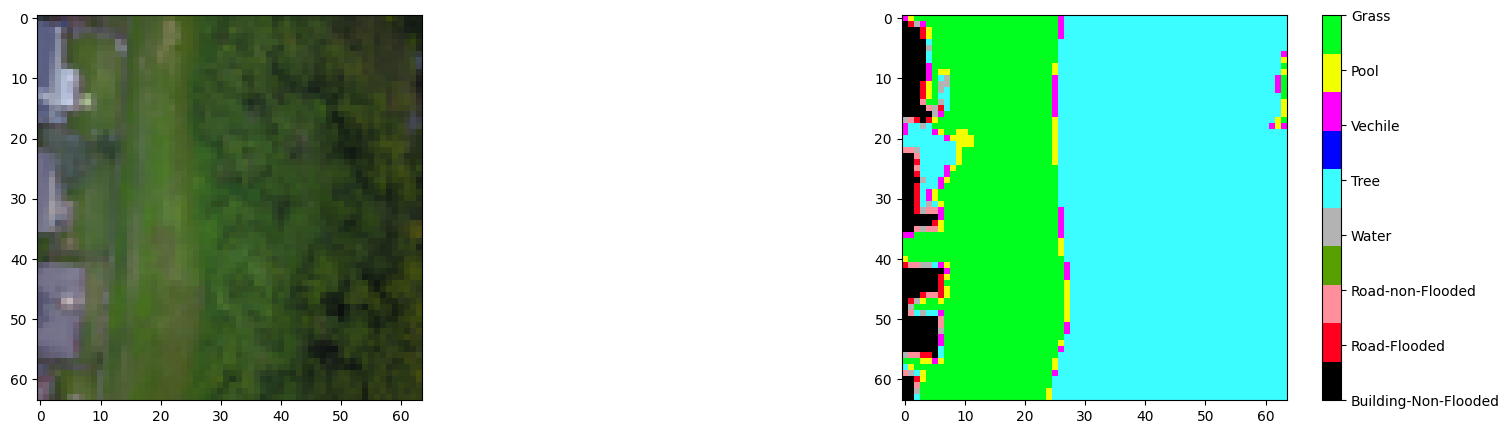

In [ ]:
#Show sample of dataset:
sample = next(iter(floodnet_dataloader_train))

plt.figure(figsize=(20, 5))
plt.subplot(1,2,1)
plt.imshow(sample[0][0].permute(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow(sample[1][0].permute(1, 2, 0), cmap=colormap)  # for visualization we have to remove 3rd dimension of mask

cbar = plt.colorbar(ticks=range(10), format='%1i', cmap=colormap)
cbar.ax.set_yticklabels(class_names)

plt.show()

In [ ]:
#Define Accuracy metric:
def acc(label, predicted):
    seg_acc = (label.cpu() == torch.argmax(predicted, axis=1).cpu()).sum() / torch.numel(label.cpu())
    return seg_acc

In [ ]:
N_EPOCHS = 3

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=10,                      # model output channels (number of classes in your dataset)
)

if str(device) == 'cuda':
        print("model is cuda")
        model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = smp.losses.DiceLoss('multiclass', from_logits=True)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.5)
min_loss = torch.tensor(float('inf'))

os.makedirs('./saved_models', exist_ok=True)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 247MB/s]


model is cuda


In [ ]:
import copy

plot_losses = []
scheduler_counter = 0
best_model = None

for epoch in range(N_EPOCHS):
  # training
  model.train()
  loss_list = []
  acc_list = []
  for batch_i, (x, y) in enumerate(floodnet_dataloader_train):
      pred_mask = model(x.to(device).float())
      loss = criterion(pred_mask, y.to(device).type(torch.int64))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      loss_list.append(loss.cpu().detach().numpy())
      acc_list.append(acc(y,pred_mask).numpy())

      print(
          "\r[Epoch %d/%d] [Batch %d/%d] [Loss: %f (%f)]"
          % (
              epoch,
              N_EPOCHS,
              batch_i,
              len(floodnet_dataloader_train),
              loss.cpu().detach().numpy(),
              np.mean(loss_list),
          )
      )
  scheduler_counter += 1
  # testing
  model.eval()
  val_loss_list = []
  val_acc_list = []
  for batch_i, (x, y) in enumerate(floodnet_dataloader_test):
      with torch.no_grad():
          pred_mask = model(x.to(device).float())
      val_loss = criterion(pred_mask, y.to(device).type(torch.int64))
      val_loss_list.append(val_loss.cpu().detach().numpy())
      val_acc_list.append(acc(y,pred_mask).numpy())

  print(' epoch {} - loss : {:.5f} - acc : {:.2f} - val loss : {:.5f} - val acc : {:.2f}'.format(epoch,
                                                                                                  np.mean(loss_list),
                                                                                                  np.mean(acc_list),
                                                                                                  np.mean(val_loss_list),
                                                                                                  np.mean(val_acc_list)))
  plot_losses.append([epoch, np.mean(loss_list), np.mean(val_loss_list)])

  compare_loss = np.mean(val_loss_list)
  is_best = compare_loss < min_loss
  if is_best == True:
    scheduler_counter = 0
    min_loss = min(compare_loss, min_loss)
    torch.save(model.state_dict(), './saved_models/unet_epoch_{}_{:.5f}.pt'.format(epoch,np.mean(val_loss_list)))
    best_model = copy.deepcopy(model)

  if scheduler_counter > 5:
      lr_scheduler.step()
      print(f"lowering learning rate to {optimizer.param_groups[0]['lr']}")
      scheduler_counter = 0

[Epoch 0/3] [Batch 0/91] [Loss: 0.924824 (0.924824)]
[Epoch 0/3] [Batch 1/91] [Loss: 0.830454 (0.877639)]
[Epoch 0/3] [Batch 2/91] [Loss: 0.824303 (0.859860)]
[Epoch 0/3] [Batch 3/91] [Loss: 0.911325 (0.872726)]
[Epoch 0/3] [Batch 4/91] [Loss: 0.899161 (0.878013)]
[Epoch 0/3] [Batch 5/91] [Loss: 0.902666 (0.882122)]
[Epoch 0/3] [Batch 6/91] [Loss: 0.906885 (0.885660)]
[Epoch 0/3] [Batch 7/91] [Loss: 0.889949 (0.886196)]
[Epoch 0/3] [Batch 8/91] [Loss: 0.788780 (0.875372)]
[Epoch 0/3] [Batch 9/91] [Loss: 0.766567 (0.864491)]
[Epoch 0/3] [Batch 10/91] [Loss: 0.763381 (0.855300)]
[Epoch 0/3] [Batch 11/91] [Loss: 0.657145 (0.838787)]
[Epoch 0/3] [Batch 12/91] [Loss: 0.774681 (0.833855)]
[Epoch 0/3] [Batch 13/91] [Loss: 0.842543 (0.834476)]
[Epoch 0/3] [Batch 14/91] [Loss: 0.839281 (0.834796)]
[Epoch 0/3] [Batch 15/91] [Loss: 0.844269 (0.835388)]
[Epoch 0/3] [Batch 16/91] [Loss: 0.744956 (0.830069)]
[Epoch 0/3] [Batch 17/91] [Loss: 0.826844 (0.829890)]
[Epoch 0/3] [Batch 18/91] [Loss: 0.864

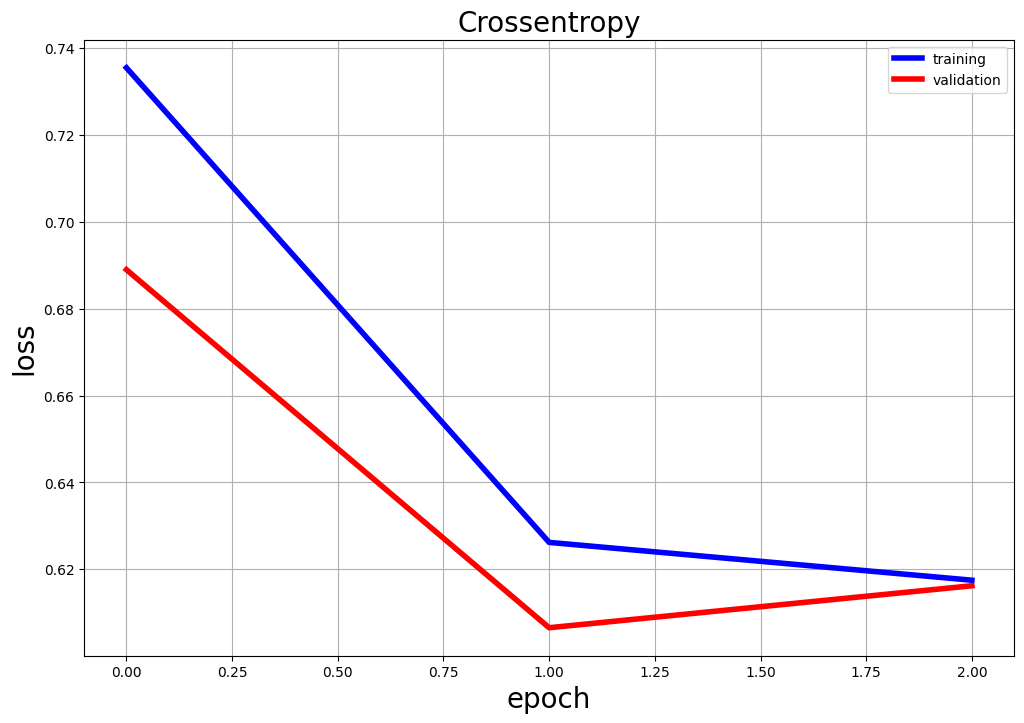

In [ ]:
# plot loss
plot_losses = np.array(plot_losses)
plt.figure(figsize=(12,8))
plt.plot(plot_losses[:,0], plot_losses[:,1], color='b', linewidth=4)
plt.plot(plot_losses[:,0], plot_losses[:,2], color='r', linewidth=4)
plt.title("Crossentropy", fontsize=20)
plt.xlabel('epoch',fontsize=20)
plt.ylabel('loss',fontsize=20)
plt.grid()
plt.legend(['training', 'validation']) # using a named size
plt.savefig('loss_plots.png')

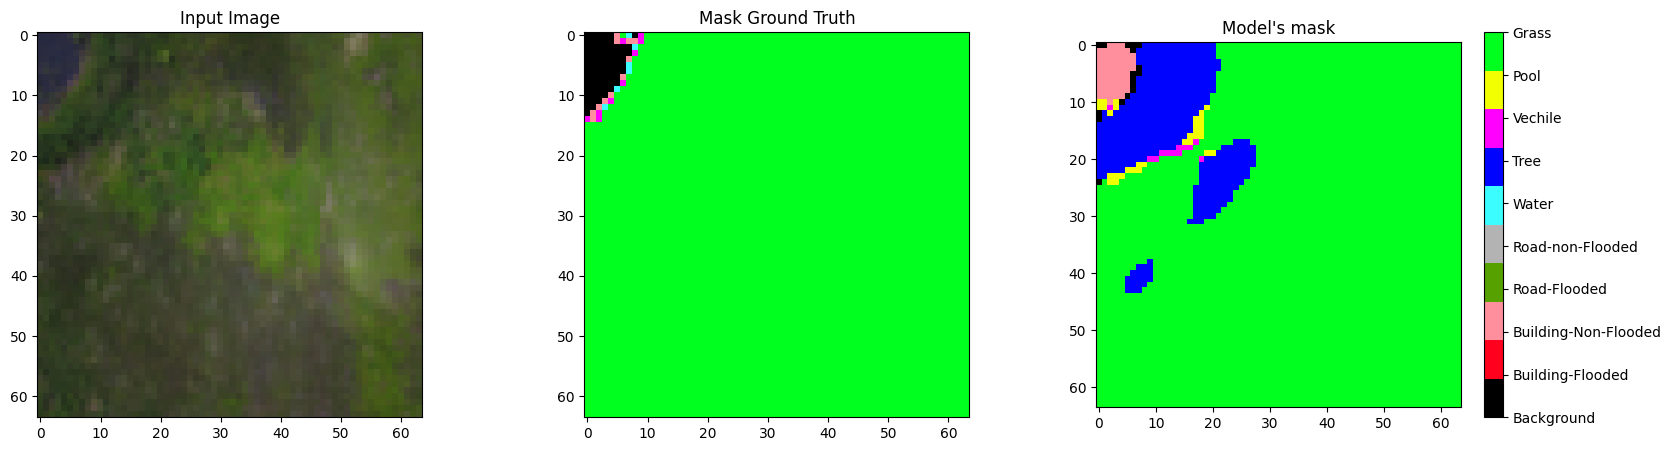

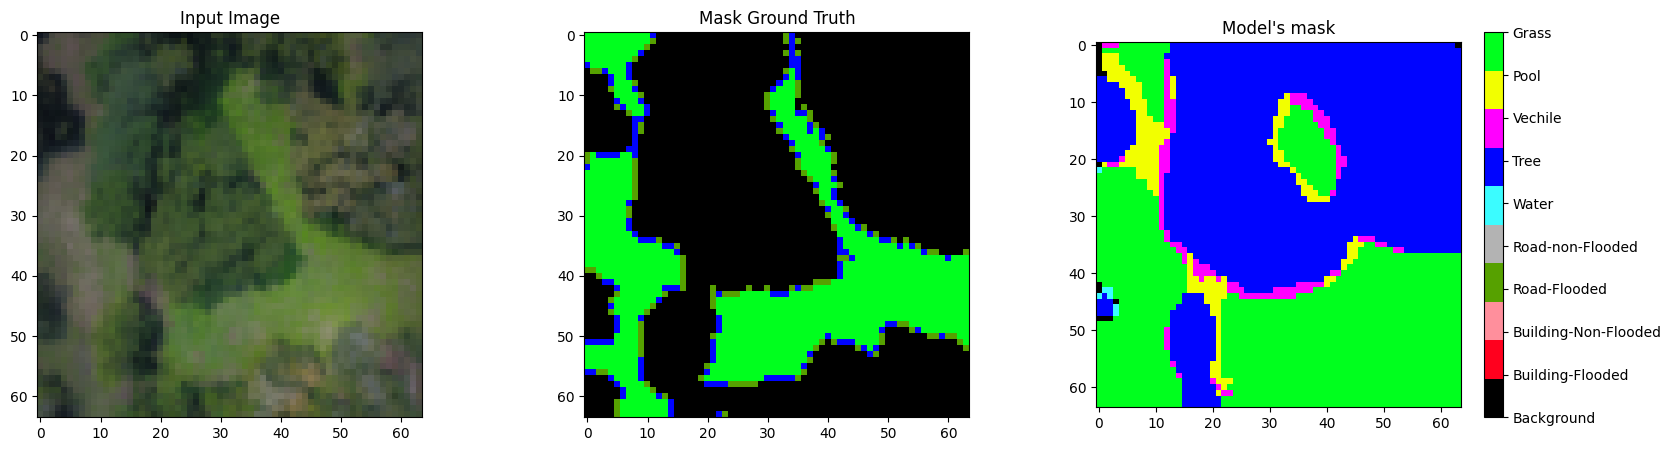

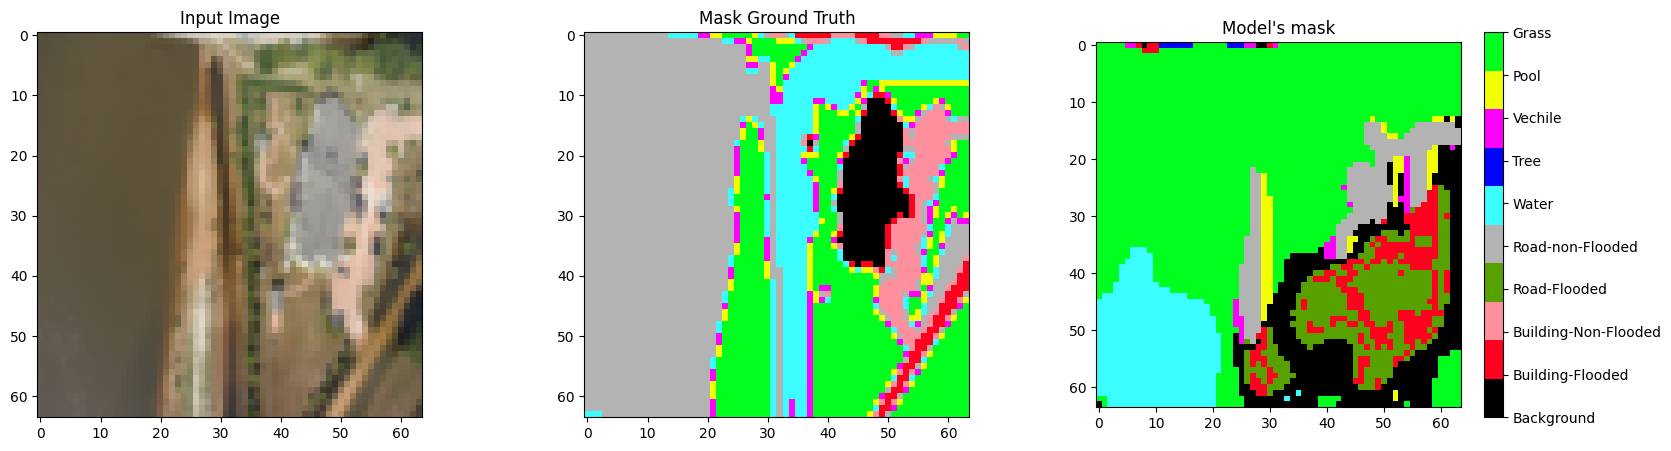

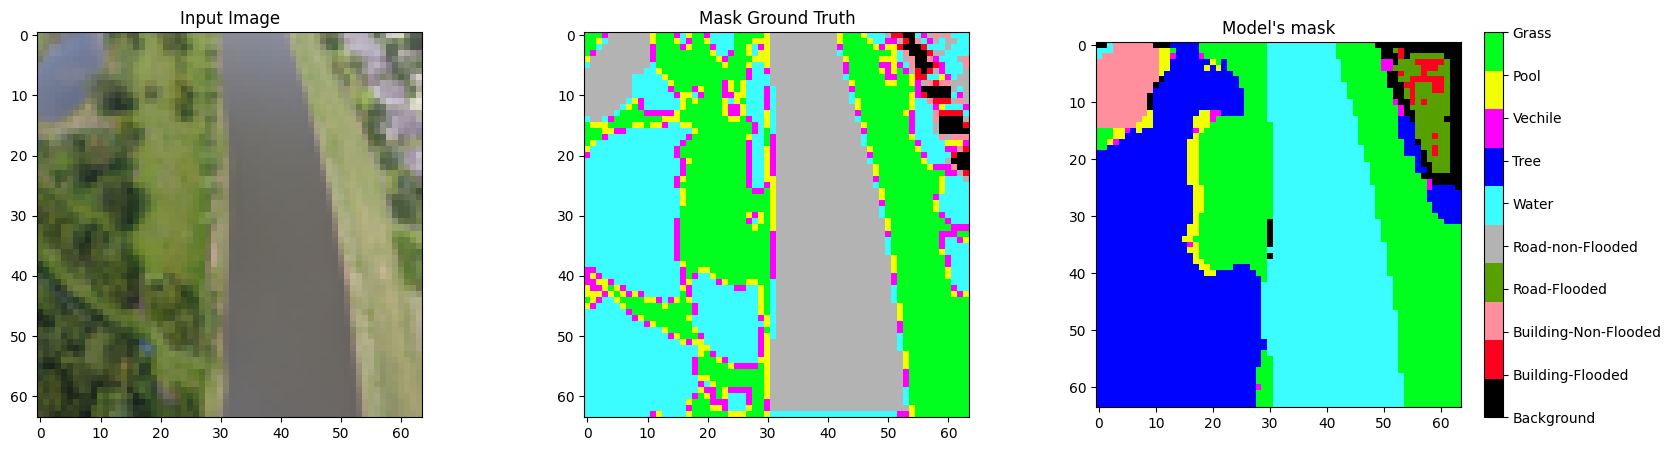

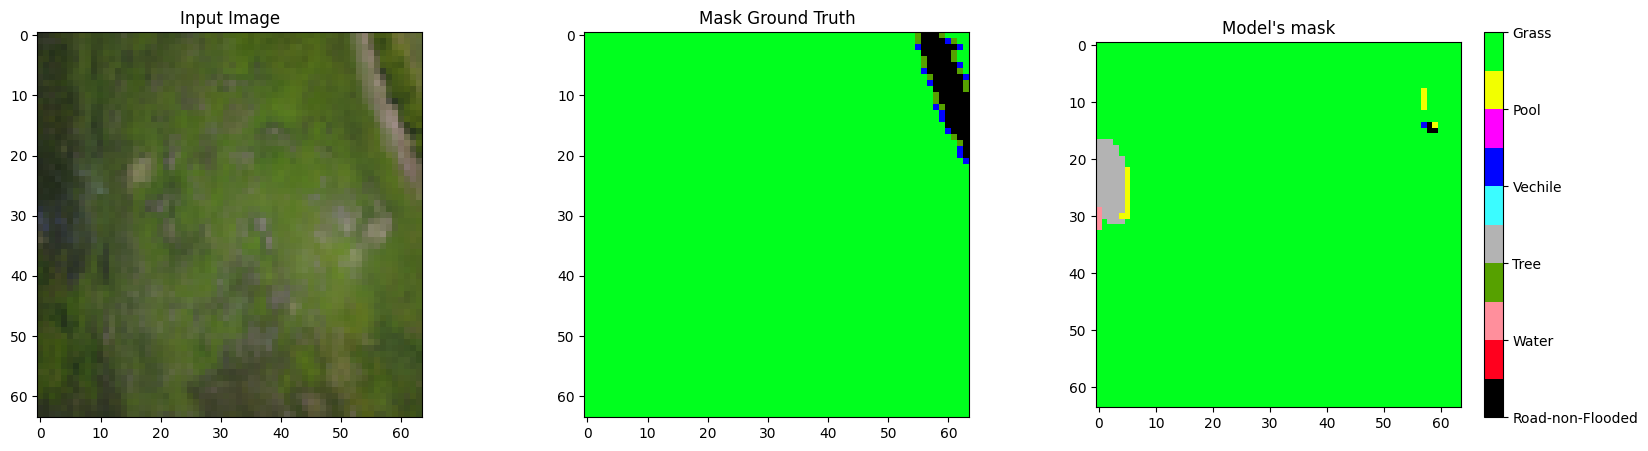

In [ ]:
# lets look at some samples
floodnet_dataloader_sample = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=0)
num_samples = 5

# Specify colors for each class using hex codes
class_colors = [
    "#000000", "#ff001e", "#ff8f9c", "#56a100",
    "#b3b3b3", "#3bfcff", "#0004ff", "#ff00ff",
    "#f2ff00", "#00ff1e"
]

class_names = [
    'Background', 'Building-Flooded', 'Building-Non-Flooded', 'Road-Flooded',
    'Road-non-Flooded', 'Water', 'Tree', 'Vechile',
    'Pool', 'Grass'
]

# Create a colormap with the given colors
colormap = ListedColormap(class_colors)
for i in range(num_samples):
    plt.figure(figsize=(20, 5))
    sample = next(iter(floodnet_dataloader_sample))
    model.eval()
    output = model(sample[0].float().to(device)).detach().type(torch.int64)
    plt.subplot(1,3,1)
    plt.title("Input Image")
    plt.imshow(sample[0][0].permute(1, 2, 0)) # for visualization we have to transpose back to HWC
    plt.subplot(1,3,2)
    plt.title("Mask Ground Truth")
    plt.imshow(sample[1].squeeze(), cmap=colormap)  # for visualization we have to remove 3rd dimension of mask
    plt.subplot(1,3,3)
    plt.title("Model's mask")
    plt.imshow(output.argmax(dim=1).squeeze().cpu(), cmap=colormap)  # for visualization we have to remove 3rd dimension of mask
    cbar = plt.colorbar(ticks=range(10), format='%1i', cmap=colormap)
    cbar.ax.set_yticklabels(class_names)

    plt.show()